<a href="https://colab.research.google.com/github/niranjana2222/Pose-Classification/blob/main/color_hpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2
from google.colab.patches import cv2_imshow
import zipfile
from zipfile import ZipFile
import os
import random

In [ ]:
#download and unzip data
correct_posture_path = '/content/correct posture-20220812T222634Z-001.zip'
incorrect_posture_path = '/content/wrong posture-20220812T230810Z-001.zip'

with zipfile.ZipFile(correct_posture_path, 'r') as zip_read:
  correct_posture_images = zip_read.extractall()

with zipfile.ZipFile(incorrect_posture_path, 'r') as zip_read:
  incorrect_posture_images = zip_read.extractall()

correct_dir = '/content/correct posture'
incorrect_dir = '/content/wrong posture'

#create empty arrays 
size = 512
X = np.zeros([427, size, size, 3])
y = np.zeros(427)
i=0

"""correct images"""
for filename in os.listdir(correct_dir):
  image_path = os.path.join(correct_dir, filename)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (size, size))

  dim = image.shape
  X[i] = image.astype(np.uint8)
  i+=1

"""incorrect images"""
for filename in os.listdir(incorrect_dir):
  image_path = os.path.join(incorrect_dir, filename)
  image = cv2.imread(image_path)
  
  if image is None:
    continue
    
  image = cv2.resize(image, (size, size))
  dim = image.shape
  X[i] = image.astype(np.uint8)
  
  y[i] = 1
  i+=1

#separate into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True)

class_names = ['Correct', 'Incorrect']


In [ ]:
#preprocess data: normalize pixels vallues
X_train = X_train / 255.0
X_test = X_test / 255.0

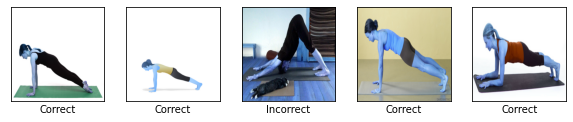

In [ ]:
#visualize data
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i].astype(int)])
plt.show()

In [ ]:

#create the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    # flatten the result to feed it to the dense layer
    tf.keras.layers.Flatten(), 
    # and define 512 neurons for processing the output coming by the previous layers
    tf.keras.layers.Dense(512, activation='relu'), 
    # a single output neuron. The result will be 0 if the image is a cat, 1 if it is a dog
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(512, 512, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
#add loss function and optimizer
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#train the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 94s 8s/step - loss: 8.2322 - accuracy: 0.4897
Epoch 2/10
11/11 [==============================] - 90s 8s/step - loss: 0.7187 - accuracy: 0.5543
Epoch 3/10
11/11 [==============================] - 91s 8s/step - loss: 0.5211 - accuracy: 0.7566
Epoch 4/10
11/11 [==============================] - 92s 8s/step - loss: 0.3365 - accuracy: 0.8592
Epoch 5/10
11/11 [==============================] - 90s 8s/step - loss: 0.1945 - accuracy: 0.9413
Epoch 6/10
11/11 [==============================] - 92s 8s/step - loss: 0.0750 - accuracy: 0.9765
Epoch 7/10
11/11 [==============================] - 91s 8s/step - loss: 0.0458 - accuracy: 0.9853
Epoch 8/10
11/11 [==============================] - 93s 8s/step - loss: 0.0209 - accuracy: 0.9941
Epoch 9/10
11/11 [==============================] - 93s 8s/step - loss: 0.0161 - accuracy: 0.9853
Epoch 10/10
11/11 [==============================] - 90s 8s/step - loss: 0.0244 - accuracy: 0.9912


In [ ]:
#evaluate on test data
loss, accuracy = model.evaluate(X_test,  y_test, verbose=0)

print('\nAccuracy:', accuracy)
print('\nLoss:', loss)
"""
print('\nF1:', f1_score)
print('\nPrecision:', precision)
print('\nRecall:', recall)
print('\nAUC:', AUC)
"""



Accuracy: 0.9069767594337463

Loss: 0.3682522773742676


"\nprint('\nF1:', f1_score)\nprint('\nPrecision:', precision)\nprint('\nRecall:', recall)\nprint('\nAUC:', AUC)\n"

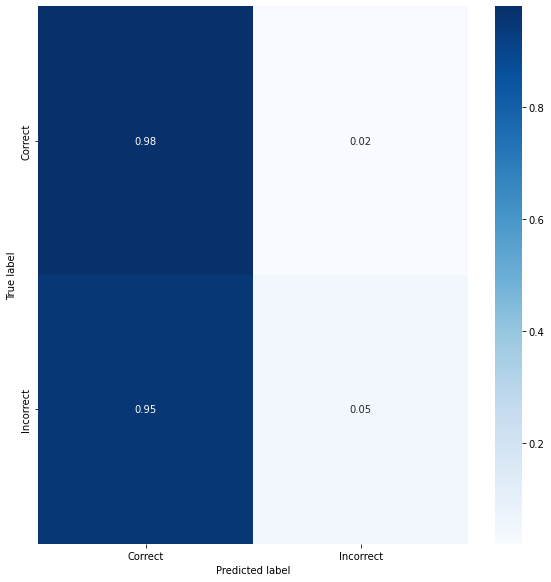

In [ ]:
import pandas as pd
import seaborn as sns

y_pred=model.predict(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_names, 
                     columns = class_names)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()